# EECS 731 Final Project - Clothing One
## Classification

In [1]:
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
reviews = pickle.load(open("../Data/reviews.pkl", "rb" ))
rented_for_encoding = pickle.load(open("../Data/rented_for_encoding.pkl", "rb"))
body_type_encoding = pickle.load(open("../Data/body_type_encoding.pkl", "rb"))
category_encoding = pickle.load(open("../Data/category_encoding.pkl", "rb"))

### Display the Dataframes from the Pickles

In [3]:
reviews.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,chest_diff
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2


In [4]:
rented_for_encoding.head()

,encoding
labels,
date,0
everyday,1
formal affair,2
other,3
party,4


In [5]:
body_type_encoding.head()

,encoding
labels,
apple,0
athletic,1
full bust,2
hourglass,3
pear,4


In [6]:
category_encoding.head()

,encoding
labels,
ballgown,0
blazer,1
blouse,2
blouson,3
bomber,4


In [7]:
#Necessary imports
from sklearn.ensemble import RandomForestClassifier #Decision Tree Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split # can split data into test test & train set
from sklearn import metrics # Can calculate how accurrate our model is
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier

### Split the Dataset Into Training and Testing Data

In [8]:
# Remove fit, the target variable, and features that
# are only received after the item has been bought.
X = reviews.drop(['fit', 'rating', 'review_date'], axis=1)
Y = reviews['fit']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,chest_diff
84461,32,1,16,66.0,620288,4,8,699477,132,590,4
76724,30,6,20,64.0,125564,7,4,565624,115,310,2
52214,23,1,20,65.0,125564,2,12,903377,140,480,3
113062,23,2,45,61.0,963476,4,1,256614,120,590,6
85702,29,1,53,70.0,2007354,1,8,550942,135,480,3


### Classifier Models:
- Random Forest (10 estimators)
- Random Forest (100 estimators)
- Gradient Boosting
- Neural Network: Multilayer Perceptron

In [9]:
# # Create classifers
rf10 = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
gb = GradientBoostingClassifier(random_state=1, learning_rate=.1)
nn = MLPClassifier()

# Train Classifers
rf10 = rf10.fit(X_train, Y_train)
rf = rf.fit(X_train, Y_train)
gb = gb.fit(X_train, Y_train)
nn = nn.fit(X_train, Y_train)

#Predict the response for test dataset
rf10_y_pred = rf10.predict(X_test)
rf_y_pred = rf.predict(X_test)
gb_y_pred = gb.predict(X_test)
nn_y_pred = nn.predict(X_test)

print("Random Forest:")
print("10 estimators Training Accuracy:", metrics.accuracy_score(Y_train, rf10.predict(X_train)))
print("10 estimators Test Accuracy:",metrics.accuracy_score(Y_test, rf10_y_pred))
print("100 estimators Training Accuracy:", metrics.accuracy_score(Y_train, rf.predict(X_train)))
print("100 estimators Test Accuracy:",metrics.accuracy_score(Y_test, rf_y_pred))

print("\nGradient Boosting:")
print("Training Accuracy:", metrics.accuracy_score(Y_train, gb.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(Y_test, gb_y_pred))

print("\nNeural Network:")
print("Training Accuracy:", metrics.accuracy_score(Y_train, nn.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(Y_test, nn_y_pred))

Random Forest:
10 estimators Training Accuracy: 0.9726397048777156
10 estimators Test Accuracy: 0.7156470949892407
100 estimators Training Accuracy: 0.9999402240743271
100 estimators Test Accuracy: 0.7314957133586092

Gradient Boosting:
Training Accuracy: 0.7371225577264654
Test Accuracy: 0.7357652764969088

Neural Network:
Training Accuracy: 0.7360892881541194
Test Accuracy: 0.7355261809611641


What % of users rate the fit of the product as "fit" to see if either model gave us additional information

In [10]:
import matplotlib.pyplot as plt

def showPie(data, words):
    if words:
        sizes = [len([x for x in data if x == "fit"]), len([x for x in data if x == "small"]), len([x for x in data if x == "large"])]
    else:
        sizes = [len([x for x in data if x == 0]), len([x for x in data if x == -1]), len([x for x in data if x == 1])]
    labels = ["Fit", "Small", "Large"]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%4.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()

Fit   %: 0.7359766636380405
Small %: 0.1340474515135161
Large %: 0.12997588484844344


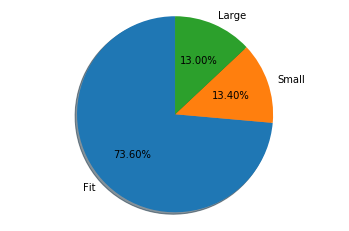

In [11]:
print("Fit   %:", ((reviews[reviews.fit == 'fit'].shape[0]) / (len(reviews.index))))
print("Small %:", ((reviews[reviews.fit == 'small'].shape[0]) / (len(reviews.index))))
print("Large %:", ((reviews[reviews.fit == 'large'].shape[0]) / (len(reviews.index))))

showPie(list(reviews["fit"]), True)

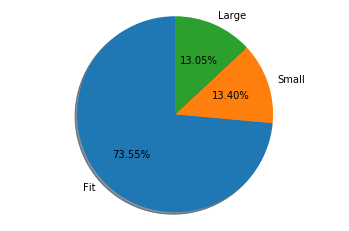

In [12]:
showPie(list(Y_test), True)

Random Forest (10 estimators):


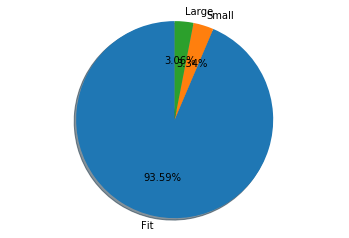

Random Forest (100 estimators):


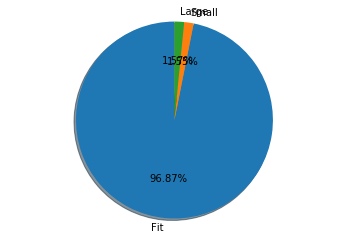

Gradient Boosting:


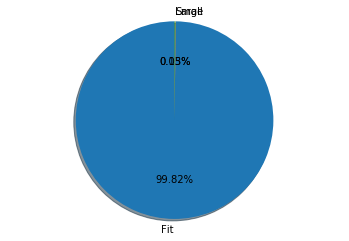

Neural Network:


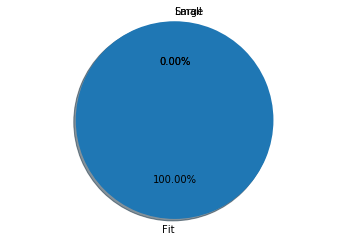

In [13]:
print("Random Forest (10 estimators):")
showPie(list(rf10_y_pred), True)
print("Random Forest (100 estimators):")
showPie(list(rf_y_pred), True)
print("Gradient Boosting:")
showPie(list(gb_y_pred), True)
print("Neural Network:")
showPie(list(nn_y_pred), True)

More information is gained simply by guessing "fit" on every item, so these models provide us no additional information.

In [14]:
# import numpy as np
rfImportances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns =['importance']).sort_values('importance', ascending=False)
gbImportances = pd.DataFrame(gb.feature_importances_, index = X_train.columns, columns =['importance']).sort_values('importance', ascending=False)
rfImportances

,importance
item_id,0.201525
user_id,0.173966
age,0.121838
weight,0.103178
height,0.091642
rented_for,0.058593
size,0.054486
body_type,0.052742
bust_volume,0.051432
chest_diff,0.050890


In [15]:
gbImportances

,importance
size,0.321014
item_id,0.218016
weight,0.205683
category,0.125788
rented_for,0.047647
age,0.022415
bust_volume,0.018113
body_type,0.017964
height,0.011069
user_id,0.009415


In [16]:
from sklearn.utils import resample
def resample_data(df):
    # Separate majority and minority classes
    df_majority = df[df.fit=='fit']
    df_minority_1 = df[df.fit=='small']
    df_minority_2 = df[df.fit=='large']

    size = df_majority.shape[0]
    
    # Upsample minority class
    df_minority_1_upsampled = resample(df_minority_1, 
                                     replace=True,     # sample with replacement
                                     n_samples=size,    # to match majority class
                                     random_state=123) # reproducible results
    
    df_minority_2_upsampled = resample(df_minority_2, 
                                     replace=True,     # sample with replacement
                                     n_samples=size,    # to match majority class
                                     random_state=123) # reproducible results
    # # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_1_upsampled, df_minority_2_upsampled]).sample(frac=1)

    return df_upsampled

In [17]:
X_train['fit'] = Y_train.values
X_test['fit'] = Y_test.values

In [18]:
X_train_resampled = resample_data(X_train)
X_test_resampled = resample_data(X_test)

In [19]:
Y_train_resampled = X_train_resampled['fit']
Y_test_resampled = X_test_resampled['fit']
X_train_resampled = X_train_resampled.drop(['fit'],axis = 1)
X_test_resampled = X_test_resampled.drop(['fit'], axis = 1)

In [20]:
def fit_to_int(x):
    if x == 'fit':
        return 0
    elif x == 'large':
        return 1
    return -1
Y_train_resampled = Y_train_resampled.map(fit_to_int)
Y_test_resampled = Y_test_resampled.map(fit_to_int)

### Display the Resampled Data

In [21]:
X_train_resampled.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,chest_diff
117637,41,5,16,62.0,148089,3,12,488486,125,390,2
105808,37,4,16,67.0,1325648,7,20,312726,170,390,1
25028,56,4,16,65.0,1514308,1,14,205559,150,480,2
66306,41,3,20,66.0,166006,2,16,925737,140,590,3
73584,34,1,44,63.0,2707303,4,8,499423,130,390,3


In [22]:
X_test_resampled.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,chest_diff
59805,30,3,16,68.0,1784020,3,20,215471,153,480,3
59549,26,3,20,66.0,466944,7,8,373117,145,710,5
132225,47,1,45,64.0,1200223,7,16,112760,123,310,1
94249,38,4,16,61.0,1656325,4,4,483420,96,390,2
71056,29,1,20,66.0,1064397,2,1,979788,125,310,1


In [23]:
Y_train_resampled.head()

117637    0
105808   -1
25028     1
66306     0
73584    -1
Name: fit, dtype: int64

In [24]:
Y_test_resampled.head()

59805    -1
59549     0
132225   -1
94249     0
71056     0
Name: fit, dtype: int64

### Classifier Models on Resampled Data:
- Random Forest (10 estimators)
- Random Forest (100 estimators)
- Gradient Boosting
- Neural Network: Multilayer Perceptron

In [25]:
# Create classifers
rf10 = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
gb = GradientBoostingClassifier()
nn = MLPClassifier()

# Train Classifers
rf10 = rf10.fit(X_train_resampled, Y_train_resampled)
rf = rf.fit(X_train_resampled, Y_train_resampled)
gb = gb.fit(X_train_resampled, Y_train_resampled)
nn = nn.fit(X_train_resampled, Y_train_resampled)

#Predict the response for test dataset
rf10_y_pred = rf10.predict(X_test_resampled)
rf_y_pred = rf.predict(X_test_resampled)
gb_y_pred = gb.predict(X_test_resampled)
nn_y_pred = nn.predict(X_test_resampled)

print("Random Forest:")
print("10 estimators Training Accuracy:", metrics.accuracy_score(Y_train_resampled, rf10.predict(X_train_resampled)))
print("10 estimators Test Accuracy:",metrics.accuracy_score(Y_test_resampled, rf10_y_pred))
print("100 estimators Training Accuracy:", metrics.accuracy_score(Y_train_resampled, rf.predict(X_train_resampled)))
print("100 estimators Test Accuracy:",metrics.accuracy_score(Y_test_resampled, rf_y_pred))

print("\nGradient Boosting:")
print("Training Accuracy:", metrics.accuracy_score(Y_train_resampled, gb.predict(X_train_resampled)))
print("Test Accuracy:",metrics.accuracy_score(Y_test_resampled, gb_y_pred))

print("\nNeural Network:")
print("Training Accuracy:", metrics.accuracy_score(Y_train_resampled, nn.predict(X_train_resampled)))
print("Test Accuracy:",metrics.accuracy_score(Y_test_resampled, nn_y_pred))

Random Forest:
10 estimators Training Accuracy: 0.9984222554786019
10 estimators Test Accuracy: 0.40116405064858673
100 estimators Training Accuracy: 0.9999690638329137
100 estimators Test Accuracy: 0.3835175381567134

Gradient Boosting:
Training Accuracy: 0.5084861773338438
Test Accuracy: 0.503715055261447

Neural Network:
Training Accuracy: 0.3333333333333333
Test Accuracy: 0.3333333333333333


On the resample: Even thirds, 33% small, 33% fit, 33% large
Gradient Boosting here is 50% more accurate than random guessing

In [26]:
#Y_test_resampled.head()
a = pd.DataFrame(Y_test_resampled)
print(a.head())

print( (len(a[a['fit'] == 0])) / (len(a.index))  )

        fit
59805    -1
59549     0
132225   -1
94249     0
71056     0
0.3333333333333333


In [27]:
# import numpy as np

rfImportances = pd.DataFrame(rf.feature_importances_, index = X_train_resampled.columns, columns =['importance']).sort_values('importance', ascending=False)
gbImportances = pd.DataFrame(gb.feature_importances_, index = X_train_resampled.columns, columns =['importance']).sort_values('importance', ascending=False)
rfImportances

,importance
item_id,0.198253
user_id,0.161386
age,0.119927
weight,0.101402
height,0.088900
size,0.078320
rented_for,0.059159
body_type,0.049181
category,0.048150
bust_volume,0.048124


In [28]:
gbImportances

,importance
size,0.418674
weight,0.195246
item_id,0.179306
category,0.084627
rented_for,0.057233
body_type,0.019177
bust_volume,0.018532
age,0.012474
height,0.006651
user_id,0.006182


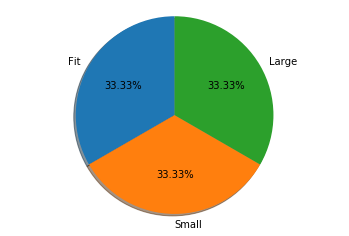

In [29]:
showPie(list(Y_test_resampled), False)

Random Forest (10 estimators):


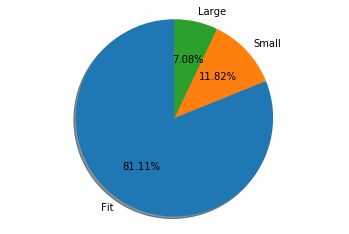

Random Forest (100 estimators):


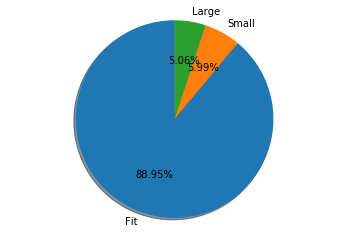

Gradient Boosting:


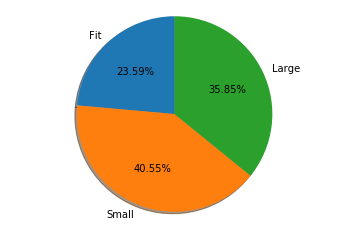

Neural Network:


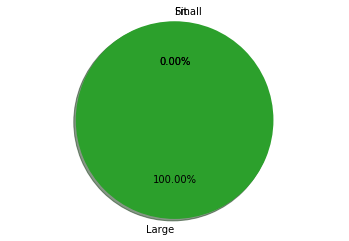

In [30]:
print("Random Forest (10 estimators):")
showPie(list(rf10_y_pred), False)
print("Random Forest (100 estimators):")
showPie(list(rf_y_pred), False)
print("Gradient Boosting:")
showPie(list(gb_y_pred), False)
print("Neural Network:")
showPie(list(nn_y_pred), False)

## Using Anomaly-Free Data

In [31]:
reviews = pickle.load(open("../Data/reviews_anomalies_removed.pkl", "rb" ))

In [32]:
# Remove fit, the target variable, and features that
# are only received after the item has been bought.
X = reviews.drop(['fit', 'rating', 'review_date'], axis=1)
Y = reviews['fit']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,chest_diff
129033,31,4,16,64.0,1746190,7,4,278562,130,310,2
61782,28,3,32,65.0,265806,7,8,356213,130,390,3
15590,58,4,20,67.0,132738,2,13,833182,133,310,1
111496,28,3,16,65.0,126335,4,12,193966,140,590,4
140918,27,4,16,65.0,148690,0,20,165402,160,590,3


### Classifier Models:
- Random Forest (10 estimators)
- Random Forest (100 estimators)
- Gradient Boosting
- Neural Network: Multilayer Perceptron

In [33]:
# # Create classifers
rf10 = RandomForestClassifier(n_estimators=10)
rf = RandomForestClassifier(n_estimators=100)
gb = GradientBoostingClassifier(random_state=1, learning_rate=.1)
nn = MLPClassifier()

# Train Classifers
rf10 = rf10.fit(X_train, Y_train)
rf = rf.fit(X_train, Y_train)
gb = gb.fit(X_train, Y_train)
nn = nn.fit(X_train, Y_train)

#Predict the response for test dataset
rf10_y_pred = rf10.predict(X_test)
rf_y_pred = rf.predict(X_test)
gb_y_pred = gb.predict(X_test)
nn_y_pred = nn.predict(X_test)

print("Random Forest:")
print("10 estimators Training Accuracy:", metrics.accuracy_score(Y_train, rf10.predict(X_train)))
print("10 estimators Test Accuracy:",metrics.accuracy_score(Y_test, rf10_y_pred))
print("100 estimators Training Accuracy:", metrics.accuracy_score(Y_train, rf.predict(X_train)))
print("100 estimators Test Accuracy:",metrics.accuracy_score(Y_test, rf_y_pred))

print("\nGradient Boosting:")
print("Training Accuracy:", metrics.accuracy_score(Y_train, gb.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(Y_test, gb_y_pred))

print("\nNeural Network:")
print("Training Accuracy:", metrics.accuracy_score(Y_train, nn.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(Y_test, nn_y_pred))

Random Forest:
10 estimators Training Accuracy: 0.9800270569425655
10 estimators Test Accuracy: 0.6564344746162928
100 estimators Training Accuracy: 0.9999754027794859
100 estimators Test Accuracy: 0.6922471467926014

Gradient Boosting:
Training Accuracy: 0.6979953265281024
Test Accuracy: 0.6909681227863046

Neural Network:
Training Accuracy: 0.6163817488623785
Test Accuracy: 0.6100944510035419


What % of users rate the fit of the product as "fit" to see if either model gave us additional information

Fit   %: 0.6149078100710365
Small %: 0.20996084141758004
Large %: 0.17513134851138354


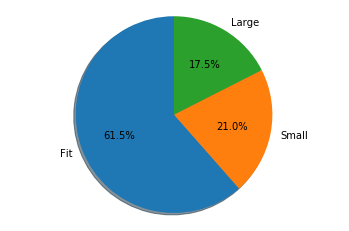

In [34]:
print("Fit   %:", ((reviews[reviews.fit == 'fit'].shape[0]) / (len(reviews.index))))
print("Small %:", ((reviews[reviews.fit == 'small'].shape[0]) / (len(reviews.index))))
print("Large %:", ((reviews[reviews.fit == 'large'].shape[0]) / (len(reviews.index))))

sizes = [reviews[reviews.fit == 'fit'].shape[0], reviews[reviews.fit == 'small'].shape[0], reviews[reviews.fit == 'large'].shape[0]]
labels = ["Fit", "Small", "Large"]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

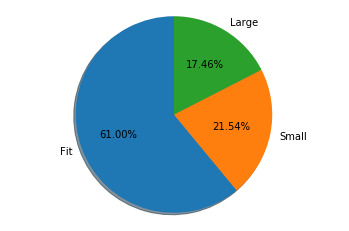

In [35]:
showPie(list(Y_test), True)

Random Forest (10 estimators):


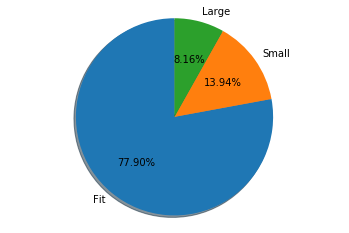

Random Forest (100 estimators):


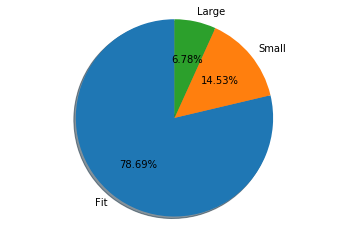

Gradient Boosting:


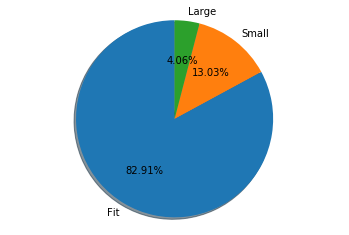

Neural Network:


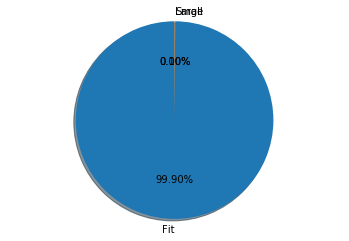

In [36]:
print("Random Forest (10 estimators):")
showPie(list(rf10_y_pred), True)
print("Random Forest (100 estimators):")
showPie(list(rf_y_pred), True)
print("Gradient Boosting:")
showPie(list(gb_y_pred), True)
print("Neural Network:")
showPie(list(nn_y_pred), True)

More information is gained simply by guessing "fit" on every item, so these models provide us no additional information.

In [37]:
import numpy as np
rfImportances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns =['importance']).sort_values('importance', ascending=False)
gbImportances = pd.DataFrame(gb.feature_importances_, index = X_train.columns, columns =['importance']).sort_values('importance', ascending=False)
rfImportances

,importance
item_id,0.217126
user_id,0.151434
age,0.115267
weight,0.111676
height,0.088406
size,0.075466
body_type,0.054234
bust_volume,0.052916
rented_for,0.051693
chest_diff,0.048859


In [38]:
gbImportances

,importance
item_id,0.571600
size,0.196928
weight,0.084649
category,0.067224
rented_for,0.022480
chest_diff,0.017373
bust_volume,0.016632
age,0.010833
body_type,0.005109
height,0.004342


In [39]:
from sklearn.utils import resample
def resample_data(df):
    # Separate majority and minority classes
    df_majority = df[df.fit=='fit']
    df_minority_1 = df[df.fit=='small']
    df_minority_2 = df[df.fit=='large']

    size = df_majority.shape[0]
    
    # Upsample minority class
    df_minority_1_upsampled = resample(df_minority_1, 
                                     replace=True,     # sample with replacement
                                     n_samples=size,    # to match majority class
                                     random_state=123) # reproducible results
    
    df_minority_2_upsampled = resample(df_minority_2, 
                                     replace=True,     # sample with replacement
                                     n_samples=size,    # to match majority class
                                     random_state=123) # reproducible results
    # # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_1_upsampled, df_minority_2_upsampled]).sample(frac=1)

    return df_upsampled

In [40]:
X_train['fit'] = Y_train.values
X_test['fit'] = Y_test.values

In [41]:
X_train_resampled = resample_data(X_train)
X_test_resampled = resample_data(X_test)

In [42]:
Y_train_resampled = X_train_resampled['fit']
Y_test_resampled = X_test_resampled['fit']
X_train_resampled = X_train_resampled.drop(['fit'],axis = 1)
X_test_resampled = X_test_resampled.drop(['fit'], axis = 1)

In [43]:
def fit_to_int(x):
    if x == 'fit':
        return 0
    elif x == 'large':
        return 1
    return -1
Y_train_resampled = Y_train_resampled.map(fit_to_int)
Y_test_resampled = Y_test_resampled.map(fit_to_int)

### Display the Resampled Data

In [44]:
X_train_resampled.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,chest_diff
9967,49,1,26,65.0,2396750,4,5,354380,114,310,1
107499,48,6,20,68.0,132738,2,9,73712,130,310,2
107664,28,1,20,63.0,154002,2,1,519782,120,390,3
83818,33,0,16,64.0,136110,2,20,23934,150,390,2
9149,40,1,16,64.0,858304,7,12,884170,135,390,3


In [45]:
X_test_resampled.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,chest_diff
129591,36,4,20,66.0,985499,2,16,214478,140,390,1
13030,26,3,32,70.0,1378631,2,17,726051,150,480,2
39198,35,2,20,70.0,131533,7,21,592782,150,480,4
75743,63,1,20,69.0,134849,2,25,485065,185,710,4
120478,33,1,16,66.0,1831026,7,4,431679,125,310,1


In [46]:
Y_train_resampled.head()

9967      1
107499    0
107664    0
83818    -1
9149     -1
Name: fit, dtype: int64

In [47]:
Y_test_resampled.head()

129591   -1
13030     1
39198     0
75743     1
120478    1
Name: fit, dtype: int64

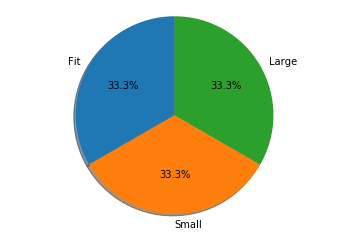

In [48]:
ytr = list(Y_test_resampled)
sizes = [len([x for x in ytr if x == 0]), len([x for x in ytr if x == -1]), len([x for x in ytr if x == 1])]
labels = ["Fit", "Small", "Large"]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

### Classifier Models on Resampled Data:
- Random Forest (10 estimators)
- Random Forest (100 estimators)
- Gradient Boosting
- Neural Network: Multilayer Perceptron

In [49]:
# Create classifers
rf10 = RandomForestClassifier(n_estimators=10)
rf = RandomForestClassifier(n_estimators=100)
gb = GradientBoostingClassifier()
nn = MLPClassifier()

# Train Classifers
rf10 = rf10.fit(X_train_resampled, Y_train_resampled)
rf = rf.fit(X_train_resampled, Y_train_resampled)
gb = gb.fit(X_train_resampled, Y_train_resampled)
nn = nn.fit(X_train_resampled, Y_train_resampled)

#Predict the response for test dataset
rf10_y_pred = rf10.predict(X_test_resampled)
rf_y_pred = rf.predict(X_test_resampled)
gb_y_pred = gb.predict(X_test_resampled)
nn_y_pred = nn.predict(X_test_resampled)

print("Random Forest:")
print("10 estimators Training Accuracy:", metrics.accuracy_score(Y_train_resampled, rf10.predict(X_train_resampled)))
print("10 estimators Test Accuracy:",metrics.accuracy_score(Y_test_resampled, rf10_y_pred))
print("100 estimators Training Accuracy:", metrics.accuracy_score(Y_train_resampled, rf.predict(X_train_resampled)))
print("100 estimators Test Accuracy:",metrics.accuracy_score(Y_test_resampled, rf_y_pred))

print("\nGradient Boosting:")
print("Training Accuracy:", metrics.accuracy_score(Y_train_resampled, gb.predict(X_train_resampled)))
print("Test Accuracy:",metrics.accuracy_score(Y_test_resampled, gb_y_pred))

print("\nNeural Network:")
print("Training Accuracy:", metrics.accuracy_score(Y_train_resampled, nn.predict(X_train_resampled)))
print("Test Accuracy:",metrics.accuracy_score(Y_test_resampled, nn_y_pred))

Random Forest:
10 estimators Training Accuracy: 0.9972054772645614
10 estimators Test Accuracy: 0.5231182795698924
100 estimators Training Accuracy: 1.0
100 estimators Test Accuracy: 0.5376344086021505

Gradient Boosting:
Training Accuracy: 0.6100310058951123
Test Accuracy: 0.5964516129032258

Neural Network:
Training Accuracy: 0.35387972906436715
Test Accuracy: 0.35376344086021505


On the resample: Even thirds, 33% small, 33% fit, 33% large
Gradient Boosting here is 50% more accurate than random guessing

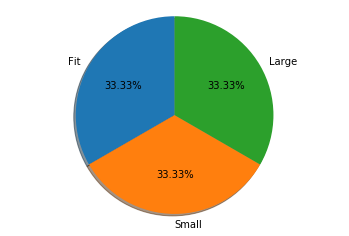

In [50]:
showPie(list(Y_test_resampled), False)

Random Forest (10 estimators):


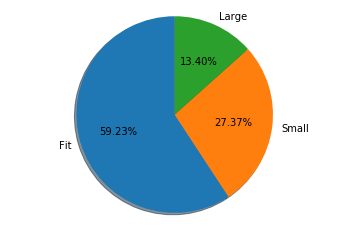

Random Forest (100 estimators):


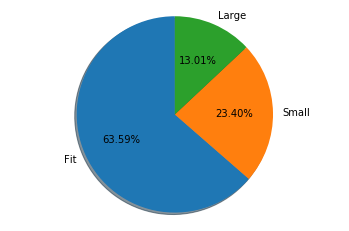

Gradient Boosting:


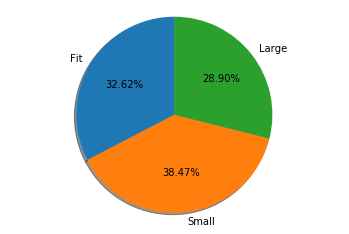

Neural Network:


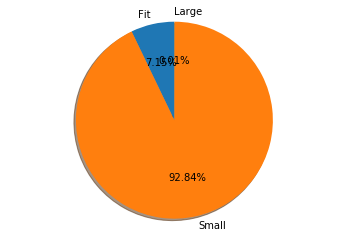

In [51]:
print("Random Forest (10 estimators):")
showPie(list(rf10_y_pred), False)
print("Random Forest (100 estimators):")
showPie(list(rf_y_pred), False)
print("Gradient Boosting:")
showPie(list(gb_y_pred), False)
print("Neural Network:")
showPie(list(nn_y_pred), False)

In [52]:
import numpy as np

rfImportances = pd.DataFrame(rf.feature_importances_, index = X_train_resampled.columns, columns =['importance']).sort_values('importance', ascending=False)
gbImportances = pd.DataFrame(gb.feature_importances_, index = X_train_resampled.columns, columns =['importance']).sort_values('importance', ascending=False)
rfImportances

,importance
item_id,0.205496
user_id,0.149734
age,0.114638
weight,0.110196
size,0.097752
height,0.086830
body_type,0.053761
bust_volume,0.050470
rented_for,0.048187
chest_diff,0.046496


In [53]:
gbImportances

,importance
item_id,0.457315
size,0.293345
weight,0.116054
category,0.065080
bust_volume,0.013727
age,0.011937
body_type,0.011804
rented_for,0.011774
chest_diff,0.007505
height,0.006418


### Create a function that plots the accuracy of different parameter values

In [54]:
def plotTunedGb(parameterName, parameters):
    train_results = []
    test_results = []
    
    for p in parameters:
        if (parameterName == "Learning Rate"):
            gb = GradientBoostingClassifier(learning_rate=p)
        elif (parameterName == "N Estimators"):
            gb = GradientBoostingClassifier(n_estimators=p)
        elif (parameterName == "Max Depth"):
            gb = GradientBoostingClassifier(max_depth=p)
        else:
            return
        
        gb.fit(X_train_resampled, Y_train_resampled)

        train_pred = gb.predict(X_train_resampled)
        acc = metrics.accuracy_score(Y_train_resampled, train_pred)
        train_results.append(acc)

        y_pred = gb.predict(X_test_resampled)
        acc = metrics.accuracy_score(Y_test_resampled, y_pred)
        test_results.append(acc)

    from matplotlib.legend_handler import HandlerLine2D

    line1, = plt.plot(parameters, train_results, 'b', label="Train Accuracy")
    line2, = plt.plot(parameters, test_results, 'r', label="Test Accuracy")

    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.title("Accuracy vs. " + parameterName)
    plt.ylabel('Accuracy')
    plt.xlabel(parameterName)
    plt.show()

    max_value = max(test_results)
    max_index = test_results.index(max_value)
    print("%s of %4.2f provided the max test accuracy of %4.4f" % (parameterName, parameters[max_index], max_value))

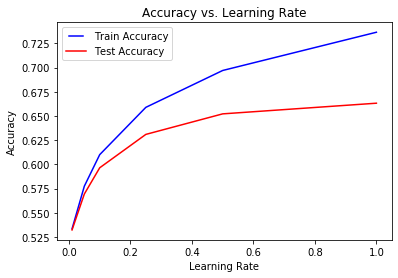

Learning Rate of 1.00 provided the max test accuracy of 0.6632


In [55]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
plotTunedGb("Learning Rate", learning_rates)

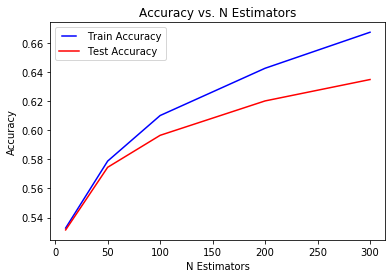

N Estimators of 300.00 provided the max test accuracy of 0.6347


In [56]:
n_estimators = [10, 50, 100, 200, 300]
plotTunedGb("N Estimators", n_estimators)

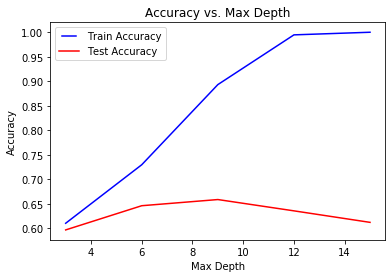

Max Depth of 9.00 provided the max test accuracy of 0.6584


In [57]:
max_depths = [3, 6, 9, 12, 15]
plotTunedGb("Max Depth", max_depths)

In [58]:
gb = GradientBoostingClassifier(learning_rate=1, n_estimators=300, max_depth=9)
gb = gb.fit(X_train_resampled, Y_train_resampled)
gb_y_pred = gb.predict(X_test_resampled)
print("\nGradient Boosting:")
print("Training Accuracy:", metrics.accuracy_score(Y_train_resampled, gb.predict(X_train_resampled)))
print("Test Accuracy:",metrics.accuracy_score(Y_test_resampled, gb_y_pred))


Gradient Boosting:
Training Accuracy: 1.0
Test Accuracy: 0.6303225806451613
